<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es7/2023_example_GNN_torchgeometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2022-2023

### example implementation of a simple GNN with pytorch geometric

code and figures from S.Raschka et al ML with pytorch course (2022).

[SLIDE](https://jamboard.google.com/d/1vHu2bKmZsYEBAygKhTYFo-CcOhVGQIAw8zSk55Ju9i8/edit?usp=sharing)

In [1]:
# install needed libraries
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric #-f https://data.pyg.org/whl/torch-1.11.0+cu113.html

In [2]:
# for compatibility https://stackoverflow.com/questions/67285115/building-wheels-for-torch-sparse-in-colab-takes-forever
import torch
print(torch.__version__)

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 26.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 18.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.5 MB/s eta 0:00:00
Looking 

In [3]:
from IPython.display import Image
%matplotlib inline


import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader# this is the torch geometric loader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np


In [4]:
# benchmark dataset QM9 (http://quantum-machine.org/datasets/.) made by small molecules with up to  23 atoms 
# (including 7 heavy atoms C, N, O, and S), 133,885 small organic molecules labeled with several geometric, 
# energetic, electronic, and thermodynamic properties
# 
# availabel in torch geometric as benchmark datasaset
dset = QM9('.') #download the dataset in currect directory
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [5]:
# example of how data are wrapped in torch geometric
# the data object is a flexible wrapper for graph data
#
# standard keyword used by geometric: 
# x: contains node features
# edge_attr: contains edge features
# edge_index: includes the edge list
# y: contains labels
#
# the QM9 data contains some additional specific attributes: 
# pos: the position of each of the molecules’ atoms in a 3D grid 
# z: the atomic number of each atom in the molecul.

# the labels in the QM9 are physical properties of the molecules (dipole moment, free energy, enthalpy, isotropic polarization,...)
# the task is to implement a GNN to predict isotropic polarization
data = dset[1]
print(data)

print("nodes in graph: ",data.num_nodes)

print('x: ', data.x)
print('y: ', data.y.shape)
print('z: ', data.z)
print('edge: ', data.edge_index.t())
print('edge attr.: ', data.edge_attr)

Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_2', z=[4])
nodes in graph:  4
x:  tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 3.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
y:  torch.Size([1, 19])
z:  tensor([7, 1, 1, 1])
edge:  tensor([[0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [2, 0],
        [3, 0]])
edge attr.:  tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


In [6]:
# it is possibile to add new attributes to the torch data wrapper

data.my_attribute = torch.tensor([1, 2, 3])
data

Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_2', z=[4], my_attribute=[3])

In [7]:
# the attributes can be moved to specific devices (cpu, gpu, ...)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.my_attribute.is_cuda #check if the attribute is in the GPU

True

Implementation of the GNN

as bonding between atomes are an important feature of the properties of the molecule, the GNN shoudl use both node and edge features

for this scope torch geometric makes available the **torch_geometric.nn.NNConv** layer:

$X^t_i = WX^{t-1}_u + \sum_{j \in N(i)} X_j^{t-1} h_w(e_{i,j})$

in which $W$ is the weigth matrix of the node, and $h_w$ is a neural network parametrized with teh parameters $w$.

NOTE: it is very similar to the basic one we have implemented last time:

$X^t_i = W_1X^{t-1}_u + \sum_{j \in N(i)} X_j^{t-1}W_2$

with the difference that now the $W_2$ equivalent, the neural network $h$, is parametrized based on the edge labels, which allows the weights to vary for different edge labels.

In [9]:
# Implementation

class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net =#W for the first conv
        conv2_net = #W for the second conv
        # NNConv arguments:
        # in_channels: size of each input sample
        # out_channels: size of each output sample
        # a torch.nn.Module neural network representing h_w
        # aggr: aggergation scheme (def: 'add', 'mean', 'max') 
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)

        self.fc_1 = # this is the classifier that read the feature space of the nodes after the pooling
        self.out = nn.Linear(32, 1)# regression
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        # torch_geometric.nn.global_add_pool: returns batch-wise graph-level-outputs by adding node features across 
        # the node dimension, so that for each single graph its output is computed by
        # https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [10]:
# split the dataset in train, validation, test
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True) #from torch_geometric.loader import DataLoader
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [16]:
ex_data = next(iter(trainloader))

In [21]:
print("N nodes : ",ex_data.num_nodes)
print("N edges : ",ex_data.num_edges)

N nodes :  561
N edges :  1160


In [11]:
# initialize the GNN
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

In [12]:
# move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
# training loop
for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)

        # as this is a regression task (predict the polarizability) we use MSE as loss
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.49 | validation avg. loss: 0.49
Epochs: 1 | epoch avg. loss: 0.14 | validation avg. loss: 0.12
Epochs: 2 | epoch avg. loss: 0.12 | validation avg. loss: 0.21
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.11


In [14]:
# performances on test set
net.eval()
predictions = []
real = []

for batch in testloader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Isotropic polarizability')

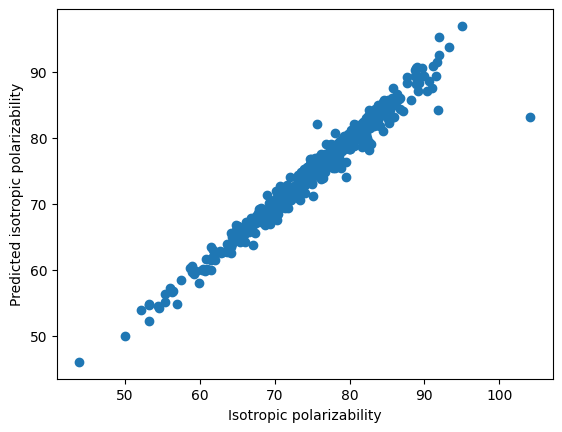

In [15]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')

In [ ]:
 '''
 A possible solution
 conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                          nn.ReLU(),
                          nn.Linear(32, 32*16))
'''